# Train an scVI model using Census data

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data. The [scvi-tools](https://scvi-tools.org/) library is built around [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/). [TileDB-SOMA-ML](https://github.com/single-cell-data/TileDB-SOMA-ML) assists with streaming Census query results to PyTorch in batches, allowing for training datasets larger than available RAM.

## Contents

1. Training the model
2. Generate cell embeddings
3. Analyzing the results

## Training the model 

Let's start by importing the necessary dependencies.

In [1]:
import warnings
from typing import Any, Dict, List

import cellxgene_census
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import tiledbsoma as soma
from tiledbsoma_ml import SCVIDataModule
import torch
from cellxgene_census.experimental.pp import highly_variable_genes
from lightning import LightningDataModule
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

/home/ubuntu/.pyenv/versions/3.12.7/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/ubuntu/.pyenv/versions/3.12.7/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


We'll now prepare the necessary parameters for running a training pass of the model.

For this notebook, we'll use a stable version of the Census:

In [2]:
census = cellxgene_census.open_soma(census_version="2025-01-30")

We'll also do two types of filtering.

For **cells**, we will apply a filter to only select primary cells, with at least 300 expressed genes (nnz >= 300). For notebook demonstration purposes, we will also apply a tissue filtering so that the training can happen on a laptop. The same approach can be used on datasets much larger than available RAM. (A GPU is recommended, though.)

For **genes**, we will apply a filter so that only the top 8000 highly variable genes (HVG) are included in the training. This is a commonly used dimensionality reduction approach and is recommended on production models as well.

Let's define a few parameters:

In [3]:
experiment_name = "mus_musculus"
# obs_value_filter = 'is_primary_data == True and tissue_general in ["pancreas"]'
obs_value_filter = 'is_primary_data == True and tissue_general in ["pancreas", "kidney"] and nnz >= 300'
top_n_hvg = 8000
hvg_batch = ["assay", "suspension_type"]

For HVG, we can use the `highly_variable_genes` function provided in `cellxgene_census`, which can compute HVGs in constant memory:

In [4]:
query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_value_filter),
)
print(f"{query.n_obs} obs")
query.obs(column_names=['dataset_id']).concat().to_pandas().dataset_id.astype(str).value_counts()

522076 obs


dataset_id
49e4ffcc-5444-406d-bdee-577127404ba8    301723
42bb7f78-cef8-4b0d-9bba-50037d64d8c1    125945
7b6bab5a-f9c4-4a56-9ed4-3b9079b14867     47833
48b37086-25f7-4ecd-be66-f5bb378e3aea     26555
12967895-3d58-4e93-be2c-4e1bcf4388d5     14803
98e5ea9f-16d6-47ec-a529-686e76515e39      5217
Name: count, dtype: int64

In [5]:
hvgs_df = highly_variable_genes(
    query,
    n_top_genes=top_n_hvg,
    batch_key=hvg_batch,
)
hv = hvgs_df.highly_variable
hv_idx = hv[hv].index

We will now introduce a helper class `SCVIDataModule` to connect TileDB-SOMA-ML with PyTorch Lightning. It subclasses [`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) and:

1. Uses TileDB-SOMA-ML to prepare a DataLoader for the results of a SOMA [`ExperimentAxisQuery`](https://tiledbsoma.readthedocs.io/en/1.15.0/python-tiledbsoma-experimentaxisquery.html) on the Census.
1. Derives each cell's scVI batch label as a tuple of obs attributes: `dataset_id`, `assay`, `suspension_type`, `donor_id`.
    * *Don't confuse each cell's label for scVI "batch" integration with a training data "batch" generated by the DataLoader.*
1. Converts the RNA counts and batch labels to a dict of tensors for each training data batch, as scVI expects.

In [6]:
hvg_query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_value_filter),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
)

datamodule = SCVIDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=1024,
    shuffle=True,
    seed=42,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

(522076, 8000, 109)

Most parameters to `SCVIDataModule` are passed through to the [`tiledbsoma_ml.ExperimentDataset`](https://single-cell-data.github.io/TileDB-SOMA-ML/#tiledbsoma_ml.ExperimentDataset) initializer; see that documentation to understand how it can be tuned.

In particular, here are some parameters of interest:

* `shuffle`: shuffles the result cell order, which is often advisable for model training.
* `batch_size`: controls the size (number of cells) in each training data batch, in turn controlling memory usage.
* `dataloader_kwargs`: [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) tuning, for example controlling parallelization.

We can now create the scVI model object:

In [7]:
n_layers = 1
n_latent = 50

model = scvi.model.SCVI(
    n_layers=n_layers,
    n_latent=n_latent,
    gene_likelihood="nb",
    encode_covariates=False,
)

Then, we can invoke the `.train` method which will start the training loop. For this demonstration, we'll only do a single epoch, but this should likely be increased for a production model. The scVI models hosted in CELLxGENE have been trained for 100 epochs.

In [8]:
%%time
model.train(
    datamodule=datamodule,
    max_epochs=10,
    early_stopping=False,
    devices=-1,
    strategy="ddp_notebook_find_unused_parameters_true",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 351 ms, sys: 610 ms, total: 961 ms
Wall time: 15min 16s


We can now save the trained model. As of the current writing, scvi-tools doesn't support saving a model that wasn't generated through an AnnData loader, so we'll use some custom code:

In [9]:
model_state_dict = model.module.state_dict()
var_names = hv_idx.to_numpy()
user_attributes = model._get_user_attributes()
user_attributes = {a[0]: a[1] for a in user_attributes if a[0][-1] == "_"}

user_attributes.update(
    {
        "n_batch": datamodule.n_batch,
        "n_extra_categorical_covs": 0,
        "n_extra_continuous_covs": 0,
        "n_labels": 1,
        "n_vars": datamodule.n_vars,
        "batch_labels": datamodule.batch_labels,
    }
)

with open("model.pt", "wb") as f:
    torch.save(
        {
            "model_state_dict": model_state_dict,
            "var_names": var_names,
            "attr_dict": user_attributes,
        },
        f,
    )

We will now load the model back and use it to generate cell embeddings (the latent space), which can then be used for further analysis. Loading the model similarly involves some custom code.

In [10]:
with open("model.pt", "rb") as f:
    torch_model = torch.load(f)

    adict = torch_model["attr_dict"]
    params = adict["init_params_"]["non_kwargs"]

    n_batch = adict["n_batch"]
    n_extra_categorical_covs = adict["n_extra_categorical_covs"]
    n_extra_continuous_covs = adict["n_extra_continuous_covs"]
    n_labels = adict["n_labels"]
    n_vars = adict["n_vars"]

    latent_distribution = params["latent_distribution"]
    dispersion = params["dispersion"]
    n_hidden = params["n_hidden"]
    dropout_rate = params["dropout_rate"]
    gene_likelihood = params["gene_likelihood"]

    model = scvi.model.SCVI(
        n_layers=params["n_layers"],
        n_latent=params["n_latent"],
        gene_likelihood=params["gene_likelihood"],
        encode_covariates=False,
    )

    module = model._module_cls(
        n_input=n_vars,
        n_batch=n_batch,
        n_labels=n_labels,
        n_continuous_cov=n_extra_continuous_covs,
        n_cats_per_cov=None,
        n_hidden=n_hidden,
        n_latent=n_latent,
        n_layers=n_layers,
        dropout_rate=dropout_rate,
        dispersion=dispersion,
        gene_likelihood=gene_likelihood,
        latent_distribution=latent_distribution,
    )
    model.module = module

    model.module.load_state_dict(torch_model["model_state_dict"])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to_device(device)
    model.module.eval()
    model.is_trained = True

## Generate cell embeddings

We will now generate the cell embeddings for this model, using the `get_latent_representation` function available in scvi-tools. 

We can use another instance of the `SCVIDataModule` for the forward pass, so we don't need to load the whole dataset in memory. This will have shuffling disabled to make it easier to join the embeddings later. We also want to restore the list of scVI batch labels from the training data, ensuring our forward pass will map batch labels to tensors in the expected way (although this specific example would work regardless, since it reuses the same query).

In [11]:
inference_datamodule = SCVIDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=adict["batch_labels"],
    batch_size=1024,
    shuffle=False,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

To feed the data to `get_latent_representation`, we operate `inference_datamodule` as PyTorch Lightning would during training:

In [12]:
inference_datamodule.setup()
inference_dataloader = (
    inference_datamodule.on_before_batch_transfer(batch, None) for batch in inference_datamodule.train_dataloader()
)
latent = model.get_latent_representation(dataloader=inference_dataloader)
latent.shape

(522076, 50)

We successfully trained the model and generated embeddings using limited memory. Even on the full Census, this has been tested to run with less than 30G of memory.

## Analyzing the results

We will now take a look at the UMAP for the generated embedding. Note that this model was only trained for one epoch (for demo purposes), so we don't expect the UMAP to show significant integration patterns, but it is nonetheless a good way to check the overall health of the generated embedding.

In order to do this, we'll use `scanpy` which accepts an AnnData object, so we'll generate one using the `get_anndata` utility function:

In [13]:
adata = cellxgene_census.get_anndata(
    census,
    organism=experiment_name,
    obs_value_filter=obs_value_filter,
)

Add the generated embedding (stored in `latent`) in the obsm slot of the AnnData object:

In [14]:
# verify cell order:
assert np.array_equal(np.array(adata.obs["soma_joinid"]), inference_datamodule.train_dataset.query_ids.obs_joinids)

adata.obsm["scvi"] = latent

We can now generate the neighbors and the UMAP.

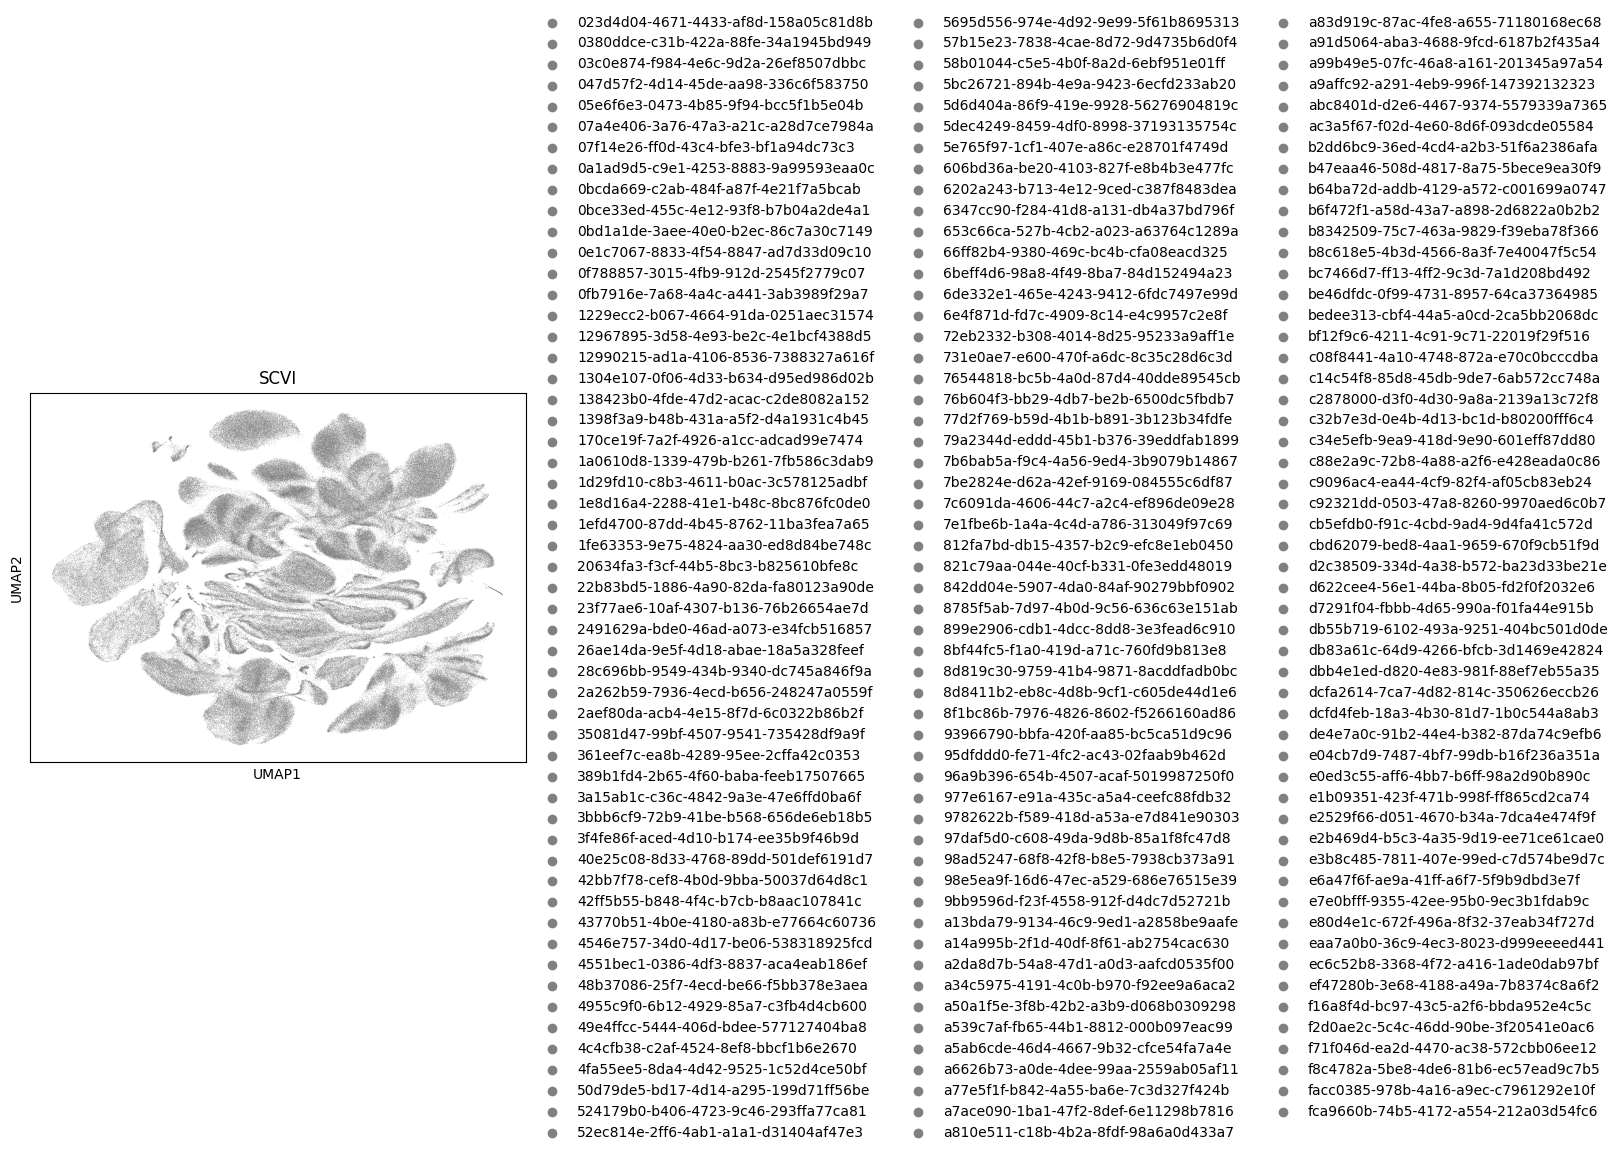

In [15]:
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")
sc.pl.umap(adata, color="dataset_id", title="SCVI")

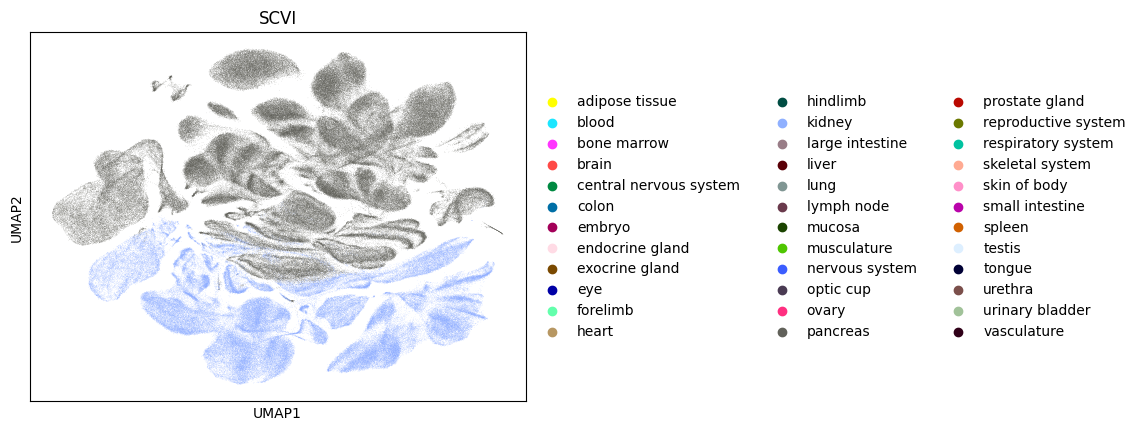

In [16]:
sc.pl.umap(adata, color="tissue_general", title="SCVI")

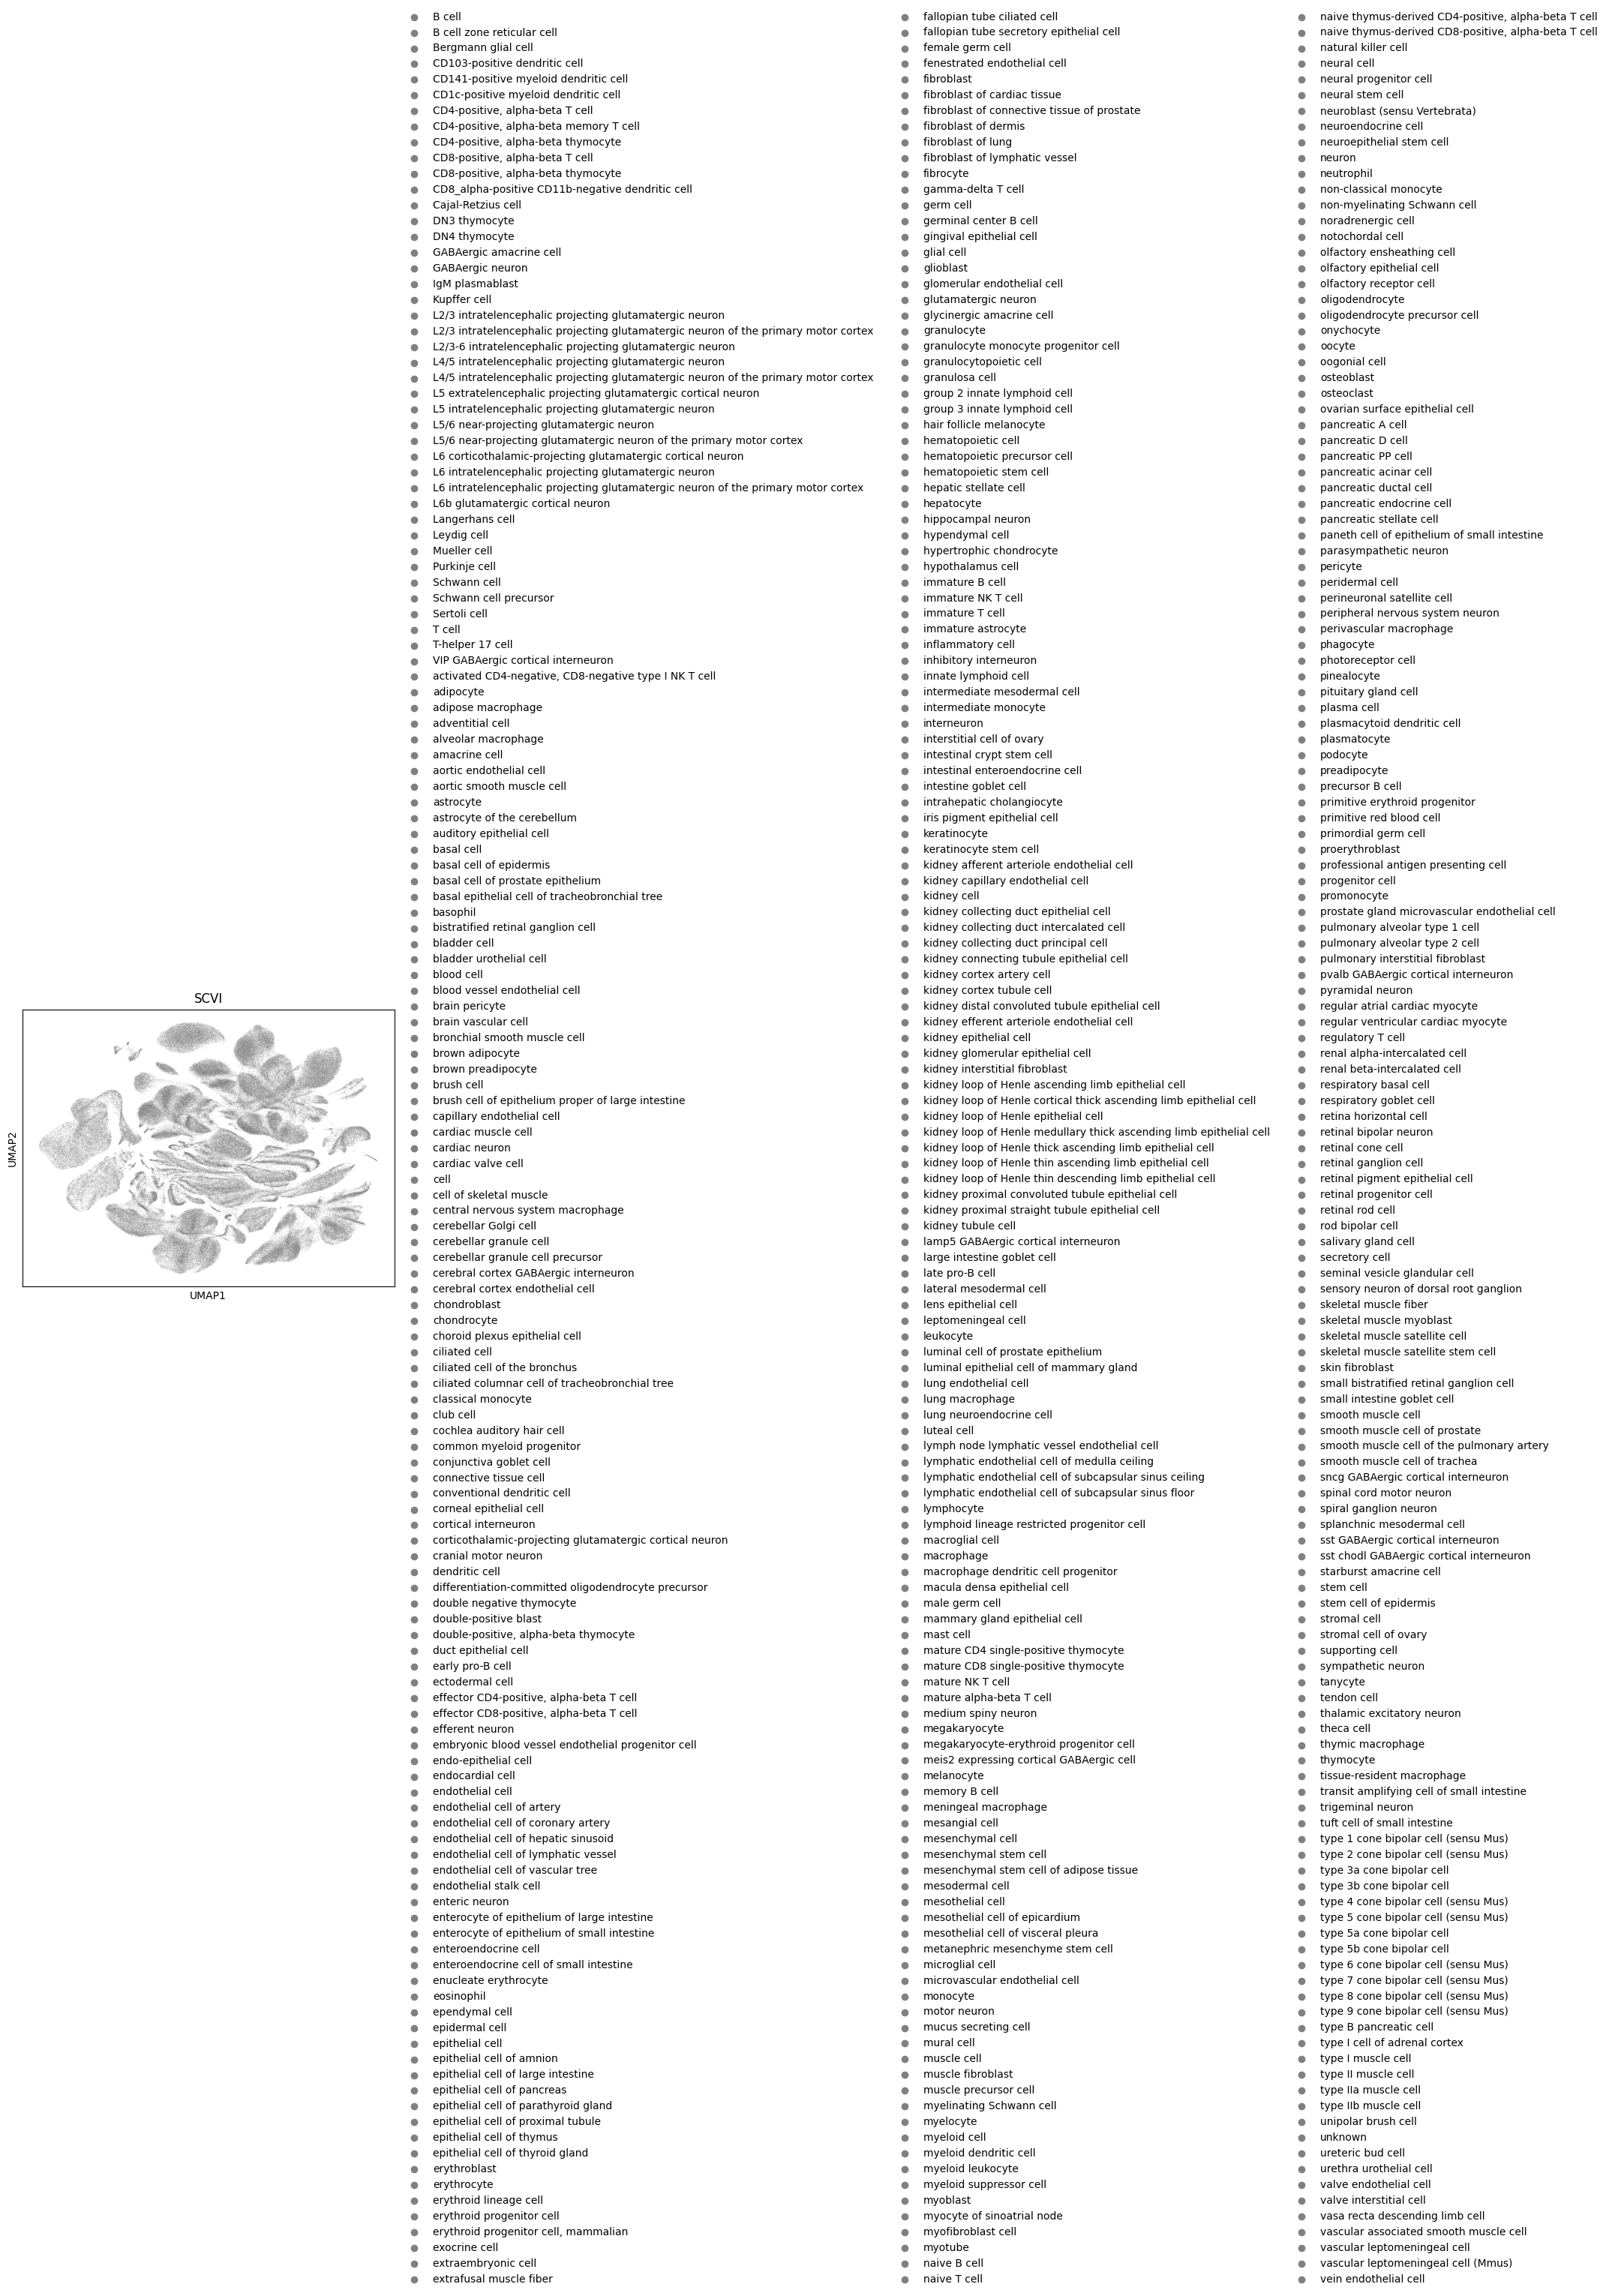

In [17]:
sc.pl.umap(adata, color="cell_type", title="SCVI")